In [1]:
"""Import all the packages we need,
this code will not work on local lab
machines due to several dependency issues.
It will work in google collab."""
import keras
import matplotlib.pyplot as plt
import numpy as np
import math
import seaborn as sns 
from IPython.display import Image
import copy


from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import decode_predictions
from keras.applications.vgg16 import VGG16


C:\Users\wukai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [48]:
"""Create an instance of a pre-trained 
VGG16 CNN that has been imported from
Keras."""
vgg = VGG16(weights='imagenet')
output_height = int(math.ceil((224-50)/5))
output_width = int(math.ceil((224-50)/5))
def occludeExp(path,model = vgg):
    """This function takes in two inputs.The path of the
    image under consideration and the model we are using
    to make predictions. It adjusts the raw image that it
    can processed by the network. We make a prediction based
    on the orginal image. Then compute the neccesary to dimensions
    to occlude over and iterate over the image. We then proceed
    to iterate over each occluded row and column pixel and make a prediction
    at each row and column. We store the results in a 2D list and return
    the heatmap."""
    raw_image = load_img(path, target_size=(224, 224))
    image = img_to_array(raw_image)
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    
    # getting the true label
    true_pred = model.predict(image)
    true_label = decode_predictions(true_pred)[0][0]
    true_index = np.argmax(true_pred[0])
    occluding_size = 50
    occluding_pixel = 0
    occluding_stride = 4
    
    #Dimensions of the image are noted so that we 
    #slide over the correct window.
    _,height, width,_ = image.shape
    output_height = int(math.ceil((height-occluding_size)/occluding_stride+1))
    output_width = int(math.ceil((width-occluding_size)/occluding_stride+1))

    heatmap = np.zeros((output_height, output_width))
    for h in range(output_height):
        for w in range(output_width):
            #occluder region is set up
            h_start = h*occluding_stride
            w_start = w*occluding_stride
            h_end = min(height, h_start + occluding_size)
            w_end = min(width, w_start + occluding_size)
            
            #Image is copied, processed, predication is made
            # and result is stored.
            input_image = copy.copy(image)
            input_image[:,h_start:h_end,w_start:w_end,:] =  occluding_pixel
            changed_image = preprocess_input(input_image)
            labels = model.predict(changed_image)
            heatmap[h,w] = labels[0][true_index] 
    return heatmap

In [67]:
#The function call is made on each of the
#images under consideration.
dogMap = occludeExp("./input/dog.jpg")
agamaMap = occludeExp("./input/agama.jpg")
magpieMap = occludeExp("./input/magpie.jpg")
pandasMap = occludeExp("./input/pandas.jpg")

(45, 45)


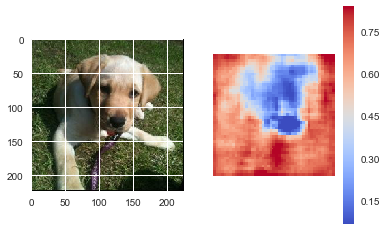

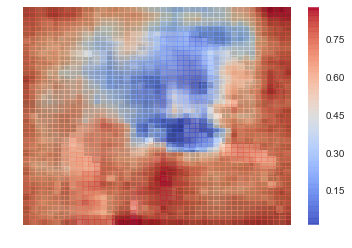

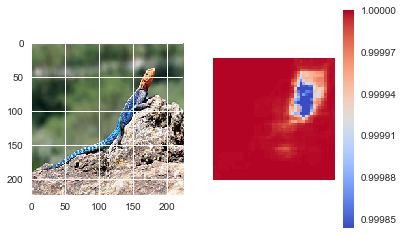

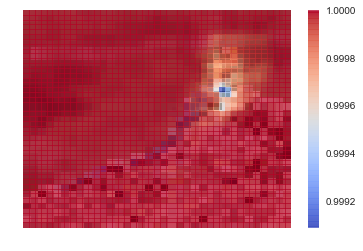

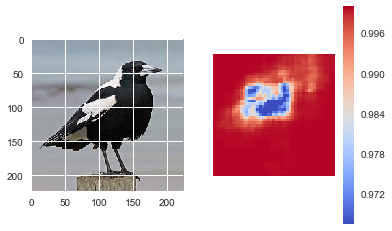

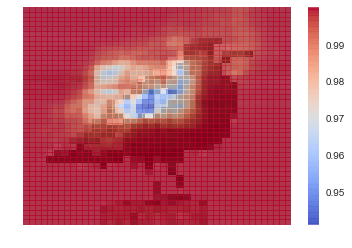

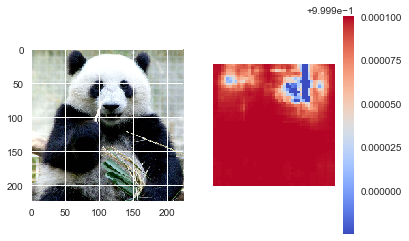

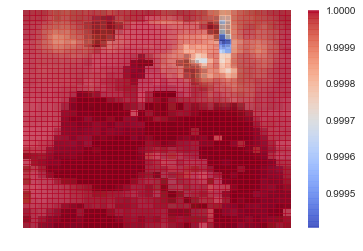

In [72]:
print(agamaMap.shape)
# add alpha (transparency) to a colormap

import matplotlib.cm 
def heatMap(path,heat):
    """This function takes in the path of an image and the
    heatmap of that image that was generated in the previous 
    function. The function displays the actual image, its heat map
    representation and another version wherein the actual image
    is superimposed over the heat map image."""
    map_img = load_img(path,target_size=(output_height, output_width))
    raw_img = load_img(path,target_size=(224, 224))
    plt.figure()
    sns.set()
    plt.subplot(1,2,1)
    plt.imshow(raw_img)
    plt.subplot(1,2,2)
    ax = sns.heatmap(heat,xticklabels=False, yticklabels=False, cmap="coolwarm", robust = True)
    plt.imshow(heat)
    plt.figure()
    hmax = sns.heatmap(heat,
            #cmap = al_winter
            cmap = matplotlib.cm.coolwarm,
            alpha = 0.7, # whole heatmap is translucent
            annot = False,
            zorder = 2,
            )
    hmax.imshow(map_img,
          aspect = hmax.get_aspect(),
          extent = hmax.get_xlim() + hmax.get_ylim(),
          zorder = 1) #put the map under the heatmap
    plt.axis('off')
heatMap("./input/dog.jpg",dogMap)
heatMap("./input/agama.jpg",agamaMap,)
heatMap("./input/magpie.jpg",magpieMap)
heatMap("./input/pandas.jpg",pandasMap)